# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Загрузим данные и рассмотрим их.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from tqdm import tqdm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Правильное решение — выделять отдельную ячейку в начале проекта под подключение библиотек и настройки. Tак код легче поддерживать 👌 Но также стоит соблюдать рекомендации PEP-8 при написании кода. У импортов есть тоже определенные правила. Это сделано для повышения читабельности и простоты работы с кодом.

https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html
</div>

## Подготовка данных

In [2]:
data = pd.read_csv("/datasets/autos.csv")
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Всего в данных 354369 строк, в некоторых столбцах присутствуют пропуски. Рассмотрим столбцы с пропусками и приму решение, как с ними бороться.

In [4]:
data["VehicleType"].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [5]:
data["VehicleType"].isna().sum()/len(data)

0.1057936783409384

В столбце видим 10% пропусков, для удаления данных это достаточно большая велечина. Поэтому считаю необходимым заменить нулевые значения в столбце заглушкой. 

In [6]:
data["VehicleType"] = data["VehicleType"].fillna("no_type")

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 👍
</div>

In [7]:
data["RegistrationYear"].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

<AxesSubplot:>

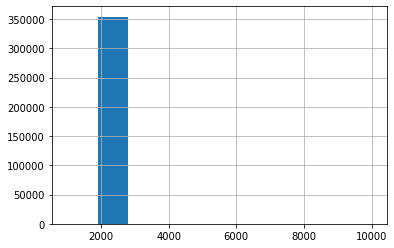

In [8]:
data["RegistrationYear"].hist()

В столбце RegistrationYear очень много выбросов, которые просто невозможны по логике, так как автомобили были изобретены только в 1885 году. Я считаю необходимым ограничить данные в столбце диапазоном от 1900, так как теоретически возможна продажа раритеных автомобилей до настоящего времени.

In [9]:
data = data[(data["RegistrationYear"] >= 1900)&(data["RegistrationYear"] <= 2016)]
len(data)

339773

<div class="alert alert-block alert-danger">
<b>❌ Замечание:</b>

Максимальный год — год выгрузки 2016.
</div>

<div class="alert alert-block alert-info">
<b>Изменения:</b> Изменил верхнюю границу года регистрации.
</div>

In [10]:
data["Gearbox"].unique()

array(['manual', 'auto', nan], dtype=object)

In [11]:
data["Gearbox"].isna().sum()/len(data)

0.05270872023380316

В столбце с коробкой передач всего 5.5% пропусков, зная что распределение этого столбца биномиальное и добавление 3-его значения в виде заглушки только загрязнит данные, считаю необходимым удалить все пропуска.

In [12]:
data = data.dropna(subset = ["Gearbox"])

In [13]:
data["Model"].isna().sum()/len(data)

0.043313324882559096

Пропуска в столбце с моделями заменим заглушкой "no_model"

In [14]:
data["Model"] = data["Model"].fillna("no_model") 

Рассмотрим столбце Kilometer на наличие выбросов

<AxesSubplot:>

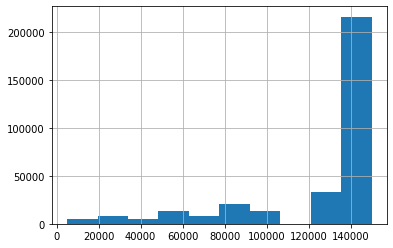

In [15]:
data["Kilometer"].hist()

Аномальных значений пробега не наблюдается

In [16]:
data["FuelType"].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Пропуски в столбце с топливом отнесем к категории other.

In [17]:
data["FuelType"] = data["FuelType"].fillna("other")

In [18]:
data["NotRepaired"].unique()

array([nan, 'yes', 'no'], dtype=object)

In [19]:
data["NotRepaired"].isna().sum()/len(data)

0.16569109934630777

Количество пропусков в столбце с ремонтом 17.5 процентов. Это очень много для удаления, поэтому отесем все пропуска к категории "unknown"

In [20]:
data["NotRepaired"] = data["NotRepaired"].fillna("unknown")

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Пропуски успешно заполнены 👍 Модели теперь не будут капризничать)
</div>

Переведем столбцы DateCrawled, DateCreated, LastSeen в формат datetime.

In [21]:
data["DateCrawled"]= pd.to_datetime(data["DateCrawled"], format = "%Y-%m-%d %H:%M:%S")
data["DateCreated"]= pd.to_datetime(data["DateCreated"], format = "%Y-%m-%d %H:%M:%S")
data["LastSeen"]= pd.to_datetime(data["LastSeen"], format = "%Y-%m-%d %H:%M:%S")

Также необходимо удалить все не связанные с целевым признаком столбцы. Считаю, что столбцы DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen никак не влияют на цену автомобиля. Удалю их.

In [22]:
data = data.drop(["DateCrawled", "DateCreated", "NumberOfPictures", "PostalCode", "LastSeen"], axis = 1)

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Удалить неинформативные признаки - хорошее решение 👍
</div>

Рассмотрим столбец RegistrationMonth

In [23]:
for i in range(0,13):
    print(i, (data["RegistrationMonth"] == i).sum())

0 24855
1 21619
2 20005
3 32357
4 27447
5 27329
6 29435
7 25551
8 21177
9 22435
10 24514
11 22392
12 22748


В нем всего 13 различных значений, что совершенно не соответствует логике. В отличии от удаленных столбцов у него может быть зависимость от категорального признака. Проверим наличие линейной зависимости.

In [24]:
data["RegistrationMonth"].corr(data["Price"])

0.08597050316204201

Линейная зависимость маленькая, также плохо видны причинноследственная зависимость между столбцами, так как обычно покупатели смотрят на год регистрации машины, поэтому удалим этот столбец.

In [25]:
data = data.drop("RegistrationMonth", axis = 1)

Рассмотрим распределение значений в столбце Price.

<AxesSubplot:>

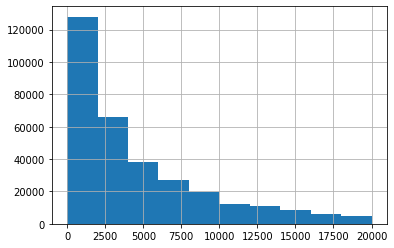

In [26]:
data["Price"].hist()

<AxesSubplot:>

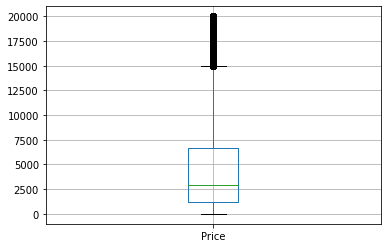

In [27]:
data.boxplot("Price")

In [28]:
data["Price"].describe()

count    321864.000000
mean       4597.441068
std        4579.971144
min           0.000000
25%        1199.000000
50%        2900.000000
75%        6700.000000
max       20000.000000
Name: Price, dtype: float64

Распределение имеет хвост враво. По правилу 3-х сигм избавимся от выбросов с правой стороны.

In [29]:
data["Price"].mean() + 3 * data["Price"].std()

18337.35449945645

In [30]:
data = data[data["Price"] < 18202]

<div class="alert alert-block alert-danger">
<b>❌ Замечание:</b>

Присутствуют нулевые значения в признаке price. Цена не может быть нулевой, к тому же это целевой признак. Самое интересное, что на нескольких сайтах по продаже подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены, действительно, начинаются с 0 и 1 евро, но это единичные объявления. Не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом. Но я все-таки склоняюсь к тому, чтобы избавиться от таких данных.
</div>

<div class="alert alert-block alert-success">
<b>✔️ Успешно исправлено</b>
</div>

In [31]:
(data["Price"] < 2).sum()/(data["Price"] <= 100).sum()

0.8527545573572364

In [32]:
(data["Price"] <= 100).sum()/len(data)

0.031293434650647524

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Цена 0 и 1 входят в диапазон нормальных значений распределения цены, но по смыслу они не подходят, врядли кто-то будет продавать машину меньше, чем за 100 евро. Причем обьявления с ценой 0-1 составляют 85 процентов от обьявлений с ценой до 100 евро. Также обьявления с ценой до 100 евро составляют всего 3 процента от всех обьявлений в базе. Таким образом считаю необходимым удалить обьявления с ценой меньшей или равной 100.
</div>

In [33]:
data = data[data["Price"] > 100]

Также рассмотрим распределение в столбце Kilometer.

<AxesSubplot:>

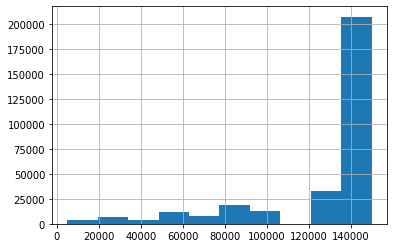

In [34]:
data["Kilometer"].hist()

<AxesSubplot:>

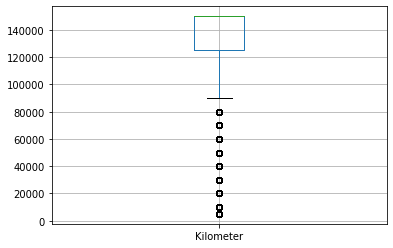

In [35]:
data.boxplot("Kilometer")

In [36]:
data["Kilometer"].describe()

count    307358.000000
mean     129159.676989
std       36275.958646
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Распределение имеет большой хвост в левую сторону. Применим правилу 3-х сигм для удаления выбросов слева.

In [37]:
data = data[data["Kilometer"] > data["Kilometer"].mean() - 3 * data["Kilometer"].std()]

Все проблемы с данными были устранены, далее приступим к обучению и тестированию моделей.

<div class="alert alert-block alert-danger">
<b>❌ Замечание:</b>

В признаке 'power' есть выбросы и аномалии. Мощность можно ограничить максимальной и минимальной приемлемыми значениями
</div>

<div class="alert alert-block alert-success">
<b>✔️ Успешно исправлено</b>
</div>

<AxesSubplot:>

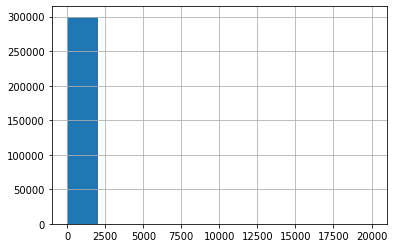

In [38]:
data["Power"].hist()

In [39]:
data["Power"].describe()

count    299984.000000
mean        114.987616
std         171.907850
min           0.000000
25%          75.000000
50%         107.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

<AxesSubplot:>

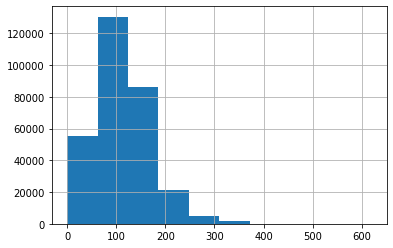

In [40]:
data = data[data["Power"] < data["Power"].mean() + 3 * data["Power"].std()]
data["Power"].hist()

In [41]:
(data["Power"] < 10).sum()/len(data)

0.07031703557391379

In [42]:
data = data[data["Power"] > 10]

## Обучение моделей

По заданию проекта нам необходимо решать задачу регрессии, а именно предсказывать цену автомобиля по признакам. Для этого будем обучать несколько моделей в том числе модель градиентного бустинга. Сравнивать и анализировать результаты. Качество модели будем оценивать с помощью метрики RMSE. RMSE больше, чем MAE восприимчив к ошибкам.

Для обучения базовых моделей необходимо закодировать категоральные признаки. Применим порядковое кодирование.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Разделим датасет на количественные и качественные признаки
</div>

In [43]:
data = data.reset_index().drop("index", axis = 1)

In [44]:
data_categ = data[["VehicleType", "Gearbox", "Model", "FuelType", "Brand", "NotRepaired"]]
data = data.drop(["VehicleType", "Gearbox", "Model", "FuelType", "Brand", "NotRepaired"], axis = 1)

In [45]:
encoder = OrdinalEncoder()
encoder.fit(data_categ)
data_code = encoder.transform(data_categ)
data_code = pd.DataFrame(data_code, columns = data_categ.columns)

In [46]:
data_code = data.join(data_code)
data_code

,Price,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,9800,2004,163,125000,7.0,0.0,117.0,2.0,14.0,1.0
1,1500,2001,75,150000,6.0,1.0,116.0,6.0,38.0,0.0
2,3600,2008,69,90000,6.0,1.0,101.0,2.0,31.0,0.0
3,650,1995,102,150000,5.0,1.0,11.0,6.0,2.0,2.0
4,2200,2004,109,150000,1.0,1.0,8.0,6.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...
278623,5250,2016,150,150000,3.0,0.0,4.0,5.0,0.0,0.0
278624,3200,2004,225,150000,5.0,1.0,140.0,6.0,30.0,2.0
278625,1199,2000,101,125000,1.0,0.0,106.0,6.0,32.0,0.0
278626,9200,1996,102,150000,0.0,1.0,224.0,2.0,38.0,0.0


In [47]:
data_code

,Price,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,9800,2004,163,125000,7.0,0.0,117.0,2.0,14.0,1.0
1,1500,2001,75,150000,6.0,1.0,116.0,6.0,38.0,0.0
2,3600,2008,69,90000,6.0,1.0,101.0,2.0,31.0,0.0
3,650,1995,102,150000,5.0,1.0,11.0,6.0,2.0,2.0
4,2200,2004,109,150000,1.0,1.0,8.0,6.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...
278623,5250,2016,150,150000,3.0,0.0,4.0,5.0,0.0,0.0
278624,3200,2004,225,150000,5.0,1.0,140.0,6.0,30.0,2.0
278625,1199,2000,101,125000,1.0,0.0,106.0,6.0,32.0,0.0
278626,9200,1996,102,150000,0.0,1.0,224.0,2.0,38.0,0.0


<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Для моделей, основанных на деревьях решений, порядковое кодирование отлично подойдет 👍
</div>

<div class="alert alert-block alert-danger">
<b>❌ Замечание:</b>

В этой кодировке важно преобразовать только категориальные признаки. Если этого не сделать, то целевая переменная тоже закодируется и метрики будут неадекватными. Можешь это исправить?) 
</div>

<div class="alert alert-block alert-success">
<b>✔️ Успешно исправлено</b>
</div>

Разделим данные на обучающую и тестовую выборку.

In [48]:
target_code = data_code["Price"]
features_code = data_code.drop("Price", axis = 1)
train_features_code, test_features_code, train_target_code, test_target_code = train_test_split(features_code, target_code, test_size = 0.25, random_state = 12345)  

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 

Данные поделены верно, пропорции выбраны адекватные 👍
</div>

Напишем свой скорер для оценки rmse. Так как нам необходима минимальная оценка rmse, в скорере будем искать отрицательное значение rmse. Далее будем искать наилучшие параметры с помощью GridSearch_CV

In [49]:
def rmse(targ, pred):
    return -1 * mean_squared_error(targ, pred, squared = False)

In [50]:
rmse_reverse = make_scorer(rmse)

Также напишем скорер для расчета rmse для кросс-валидации

In [51]:
def rmse_1(targ, pred):
    return mean_squared_error(targ, pred, squared = False)

In [52]:
rmse_score = make_scorer(rmse_1)

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Хорошие помощники 👍
</div>

Обучим решающее дерево. Применим кросс-вадидацию

In [53]:
%%time
parameter = {"max_depth": [1,100]}
model = DecisionTreeRegressor(random_state = 12345)
model_grid = GridSearchCV(model, parameter, scoring = rmse_reverse)
model_grid.fit(train_features_code, train_target_code)
model_grid.best_params_

CPU times: user 4.33 s, sys: 176 ms, total: 4.5 s
Wall time: 4.51 s


{'max_depth': 100}

In [54]:
%%time
model = DecisionTreeRegressor(random_state = 12345, max_depth = 100)
model.fit(train_features_code, train_target_code)
cross_rmse = cross_val_score(model, train_features_code, train_target_code, scoring = rmse_score).mean()
print(cross_rmse)

1793.035109644603
CPU times: user 4.34 s, sys: 28 ms, total: 4.36 s
Wall time: 4.38 s


Решающее дерево с подобранными параметрами показывает хороший результат метрики RMSE. Время кросс-валидации равняется 4.5 секунды.

Далее рассмотрим метод ближайших соседей и линейную регрессию для данной выбоки. Для этого необходимо закодировать данные в выборке One Hot Encoding, так как в данных методах. Так как эти методы используют веса features метод прямого кодирования нельзя. 

In [55]:
data_OHE = pd.get_dummies(data, drop_first = True)

In [56]:
target_OHE = data_OHE["Price"]
features_OHE = data_OHE.drop("Price", axis = 1)
train_features_OHE, test_features_OHE, train_target_OHE, test_target_OHE = train_test_split(features_OHE, target_OHE, test_size = 0.25, random_state = 12345)  

In [57]:
%%time
model = LinearRegression()
model.fit(train_features_OHE, train_target_OHE)
cross_rmse = cross_val_score(model, train_features_OHE, train_target_OHE, scoring = rmse_score).mean()
print(cross_rmse)

2843.2502138243462
CPU times: user 304 ms, sys: 538 ms, total: 842 ms
Wall time: 850 ms


<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 

Для линейных моделей прямое кодирование отлично подойдет 👍
</div>

Линейная регрессия на кросс-валидации показала ужасный результат. Метрика RMSE больше 2500. Регрессия дает очень большое количество ошибок. Попробуем провести масштабирование количественных признаков и посмотрим результат

Проведем масштабирование признаков линейной регрессии. Масштабировать будем только столбцы незакадированные OHE, так как это абсолютно бессмысленно и будет только переполнять память.

In [58]:
data_OHE_number = data_OHE[["RegistrationYear","Power", "Kilometer"]]
data_OHE_qualitative = data_OHE.drop(["RegistrationYear","Power", "Kilometer"], axis = 1)
data_OHE_qualitative = data_OHE_qualitative.reset_index().drop("index", axis = 1)

In [59]:
scaler = StandardScaler()
data_scale = scaler.fit_transform(data_OHE_number)

In [60]:
data_scale = pd.DataFrame(data_scale, columns = data_OHE_number.columns)
data_scale = data_scale.join(data_OHE_qualitative)

In [61]:
target_scale = data_scale["Price"]
features_scale = data_scale.drop("Price", axis = 1)
train_features_scale, test_features_scale, train_target_scale, test_target_scale = train_test_split(features_scale, target_scale, test_size = 0.25, random_state = 12345)  

In [62]:
%%time
model = LinearRegression()
model.fit(train_features_scale, train_target_scale)
cross_rmse = cross_val_score(model, train_features_scale, train_target_scale, scoring = rmse_score).mean()
print(cross_rmse)

2843.250213824346
CPU times: user 286 ms, sys: 432 ms, total: 718 ms
Wall time: 711 ms


Масштабирование признаков не дало никакого улучшения метрики RMSE на кросс-валидации. 

Теперь приступим к обучению ансамбля на основе градиентного бустинга. Будем пользоваться алгоритмом из библиотеки lightGBM. При помощи поиска по сетке GridSearch_CV найдем оптимальные параметры модели, при которой получим лучший параметр мктрики RMSE.

In [63]:
##%%time
#parameter = {"n_estimators": [1,1000,50],"max_depth": [1,100,10], "learning_rate": [0.1, 1, 0.1]}
#model = LGBMRegressor()
#model_grid = GridSearchCV(model, parameter, scoring = rmse_reverse)
#model_grid.fit(train_features_code, train_target_code)
#model_grid.best_params_

Обучим модель с найденными гиперпараметрами и посмотрим метрику RMSE на кросс-валидации.

In [64]:
%%time
model = LGBMRegressor(n_estimators = 1000, max_depth = 100, learning_rate = 0.1)
model.fit(train_features_code, train_target_code)
cross_rmse = cross_val_score(model, train_features_code, train_target_code, scoring = rmse_score).mean()
print(cross_rmse)

1433.9200709125216
CPU times: user 2h 20min 37s, sys: 1min 21s, total: 2h 21min 59s
Wall time: 2h 22min 56s


Время обучения модели LightGBM равняется 3 минут 40 секунд. При этом метрика RMSE имеет отличный результат. Теперь рассмотрим бустинг catboost.

In [65]:
%%time
parameter = {"n_estimators": [1,1000,50],"max_depth": [1,100,10]}
model = CatBoostRegressor(verbose = False)
model_grid = GridSearchCV(model, parameter, scoring = rmse_reverse)
model_grid.fit(train_features_code, train_target_code)
model_grid.best_params_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

CPU times: user 6min 53s, sys: 1.97 s, total: 6min 55s
Wall time: 7min 21s


{'max_depth': 10, 'n_estimators': 1000}

In [66]:
%%time
model = CatBoostRegressor(max_depth = 10, n_estimators = 1000, verbose = False)
model.fit(train_features_code, train_target_code)
cross_rmse = cross_val_score(model, train_features_code, train_target_code, scoring = rmse_score).mean()
print(cross_rmse)

1427.3574064950506
CPU times: user 5min 6s, sys: 1.18 s, total: 5min 7s
Wall time: 5min 14s


Модель catboost с оптимальными параметрами показала практичеcки такой же результат метрики RMSE на кросс-валидации. При этом время обучения модели повысилось на 1.5 минуты.

Сделаем выводы.

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

По модельной части замечаний нет - все сделано четко 💪
</div>

## Анализ моделей

Модели градиентного бустинга дают лучший результат метрики RMSE, чем базовые модели линейной регрессии и дерева решений. Но время обучения моделей бустинга гораздо выше, причем время обучения catboost, на 1.5 минуты больше, чем модели lightGBM. Таким образом, считаю лучшей модель градиетного бустинга lightGBM по совокупности критериев метрики RMSE и времени работы. Рассмотрим метрику RMSE на тестовых данных.

In [67]:
%%time
model = LGBMRegressor(n_estimators = 1000, max_depth = 100, learning_rate = 0.1)
model.fit(train_features_code, train_target_code)
pred = model.predict(test_features_code)
print(mean_squared_error(test_target_code, pred, squared = False))

1398.697335517303
CPU times: user 1min 47s, sys: 735 ms, total: 1min 48s
Wall time: 1min 48s


Модель lightGBM показал отличный результат на тестовой выборке. Время обучения 43 секунды. Мера RMSE 337. Также рассмотрим модель Catboost для предсказания.

In [68]:
%%time
model = CatBoostRegressor(max_depth = 10, n_estimators = 1000, verbose = False)
model.fit(train_features_code, train_target_code)
pred = model.predict(test_features_code)
print(mean_squared_error(test_target_code, pred, squared = False))

1391.2502620601601
CPU times: user 58.5 s, sys: 131 ms, total: 58.7 s
Wall time: 1min


Модель catboost имеет время обучения на 15 секунд больше, при этом RMSE почти такой же как у lightGBM. 

Мы рассмотрели датасет с данными по автомобилям, провели предобработку данных, рассмотрели распределение некоторых столбцов и избавились от критических значений. Далее я обучил несколько моделей на подготовленных данных и и провел их кроссвалидацию. Проведя сравнение значений метрики RMSE при кросс-валидации, а также время обучения и предсказания моделей, я сделал вывод о том, что лучшей для данного датасета будет модель lighyGBM, так как она дала такой же результат, как модель catboost, но время обучения и предсказания у нее меньше. Все задачи проекта выполнены.

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Вывод соответствует исследованию 👍
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Я убрал выбросы в столбце Power, а также убрал нулевые значения в остальных столбцах в датасете. Также мной был изменен алгоритм прямого кодирования - кодировались только категоральные признаки. Далее я провел обучение моделей на предобработаном датасете, а алгоритмы деревьев и ансамбли бустинга на датасете закодированном с помощью прямого кодироания, а модели регрессии на датасете закодированном OHE. После изменения алгоритма OrdinalEncoder значения RMSE повысились, так как при кодировании всех столбцов значения в них уменьшились, а значит RMSE, также уменьшилось. Время обучения и кросс-валидации lightGBMRegressor неадекватно высоки. Мера RMSE у моделей lightGBM и Catboost примерно одинаковы. Модели на основе градиентного бустинга показали лучший результат RMSE из всех. Сравнив предсказания lightGBM и Catboost на тестовой выборке, я получил почти одинаковые результаты RMSE (у catboost чуть лучше). Время работы catboost на 50 секунд меньше, чем у lightGBM. Таким образом считаю, что модель CatboostRegressor с оптимальными параметрами, лучшая для решения задачи регрессии для данных. 
</div>

<div class="alert alert-block alert-info">
<b>Комментарий ревьюера:</b>

Спасибо за качественную работу)
</div>

# <font color='orange'>Общее впечатление</font>
* Этот проект выполнен очень хорошо
* Видно, что приложено много усилий
* Молодец, что структурируешь ноутбук, приятно проверять такие работы
* У тебя чистый и лаконичный код
* Мне было интересно читать твои промежуточные выводы
* Твой уровень подачи материала находится на высоком уровне
* Исправь, пожалуйста, мои замечания. Затем отправляй на повторную проверку
* Жду новую версию проекта 👋

# <font color='orange'>2. Общее впечатление</font>
* Спасибо за быстрое внесение правок
* Теперь проект выглядит лучше )
* Критических замечаний нет
* Молодец, отличная работа!
* Надеюсь, ревью было полезным
* Удачи в дальнейшем обучении 👋